In [0]:
import tensorflow as tf

In [0]:
pip install stellargraph

In [0]:
#!pip uninstall networkx -y

In [0]:
#!pip install networkx==2.3

In [0]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow
from tensorflow.keras  import utils 
from tensorflow.python.keras import utils

from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link='https://drive.google.com/open?id=1L02MgutSbYwxJ5Z6JVYJiv4JXEe3_K8D'
fluff, id = link.split('=')


In [0]:
import pandas
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('movie_actor_network.csv')  
data = pandas.read_csv('movie_actor_network.csv')

In [0]:
edges = [tuple(x) for x in data.values.tolist()]
B=nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [0]:
A = list(nx.connected_component_subgraphs(B))[0]

In [0]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)


In [0]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )


In [0]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)


In [0]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

In [0]:

import numpy
m=[]
a=[]
for i in movies:
  m.append(model[i])
movies_vec=numpy.array(m)
for i in actors:
  a.append(model[i])
actors_vec=numpy.array(a)



Actors only

In [0]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

In [0]:
import operator
def cosst1(number,km):
  cost1=0
  for i in range(number):
    EGO= nx.Graph()
    c=actors_vec[ClusterIndicesComp(i, km.labels_)]
    for j in range(len(c)):
      d=model.similar_by_vector(c[j])
      d=dict(d)
      
      f=max(d.items(), key=operator.itemgetter(1))[0]
      
      P=nx.ego_graph(A,str(f))
      EGO = nx.compose(P,EGO)
    nx.connected_components(EGO)
    Gc = max(nx.connected_component_subgraphs(EGO), key=len)
    number_of_nodes=Gc.number_of_nodes()
    cost_culus=number_of_nodes/len(c)
    cost1+=cost_culus
    
  costs1=cost1/number
  return costs1

  

    



In [0]:
def cosst2(number,km):
  cost2=0
  for i in range(number):
    EGO= nx.Graph()
    c=actors_vec[ClusterIndicesComp(i, km.labels_)]
    for j in range(len(c)):
      d=model.similar_by_vector(c[j])
      d=dict(d)
      
      f=max(d.items(), key=operator.itemgetter(1))[0]
      P=nx.ego_graph(A,str(f))
      EGO = nx.compose(P,EGO)
    deg=EGO.degree()
    deg=dict(deg)
    deg_sum=sum(deg.values())
    X = {n for n, d in EGO.nodes(data=True) if d['bipartite']==0}
    Y = set(EGO) - X
    cost2_culus= deg_sum/len(Y)
    cost2+=cost2_culus
  costs2=cost2/number
  return costs2

In [0]:
import operator
from sklearn.cluster import KMeans
dict_cost={}
for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
  km = KMeans(n_clusters=number_of_clusters, random_state=0).fit(actors_vec)
  cost1=cosst1(number_of_clusters,km)
  cost2=cosst2(number_of_clusters,km) 
  
  Cost = cost1*cost2

  dict_cost.update({number_of_clusters:Cost}) 
cluster_max_cost=max(dict_cost.items(), key=operator.itemgetter(1))[0]
print(dict_cost)
print("cluster with maximum cost",cluster_max_cost)

{3: 233.67155680017478, 5: 471.50817512298363, 10: 342.6919080909127, 30: 348.52044643220046, 50: 615.8365589377219, 100: 1159.0062463632273, 200: 929.168844494206, 500: 257.9764172515109}
cluster with maximum cost 100


In [0]:
km = KMeans(n_clusters=100, random_state=0).fit(actors_vec)
labels_node=km.labels_


In [0]:
# Retrieve node embeddings and corresponding subjects
node_ids=[]
node_embeddings=[]
for i in range(100):
  c=actors_vec[ClusterIndicesComp(i, labels_node)]
  
  for j in range(len(c)):
    node_embeddings.append(c[j])
    d=model.similar_by_vector(c[j])
    d=dict(d)
      
    f=max(d.items(), key=operator.itemgetter(1))[0]
    node_ids.append(f)
#node_ids = model.wv.index2word  # list of node IDs
node_embeddings=numpy.array(node_embeddings)

#  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [0]:
from sklearn.manifold import TSNE
transform = TSNE #PCA
#node_embeddings = model.wv.vectors
#print(type(node_embeddings))
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

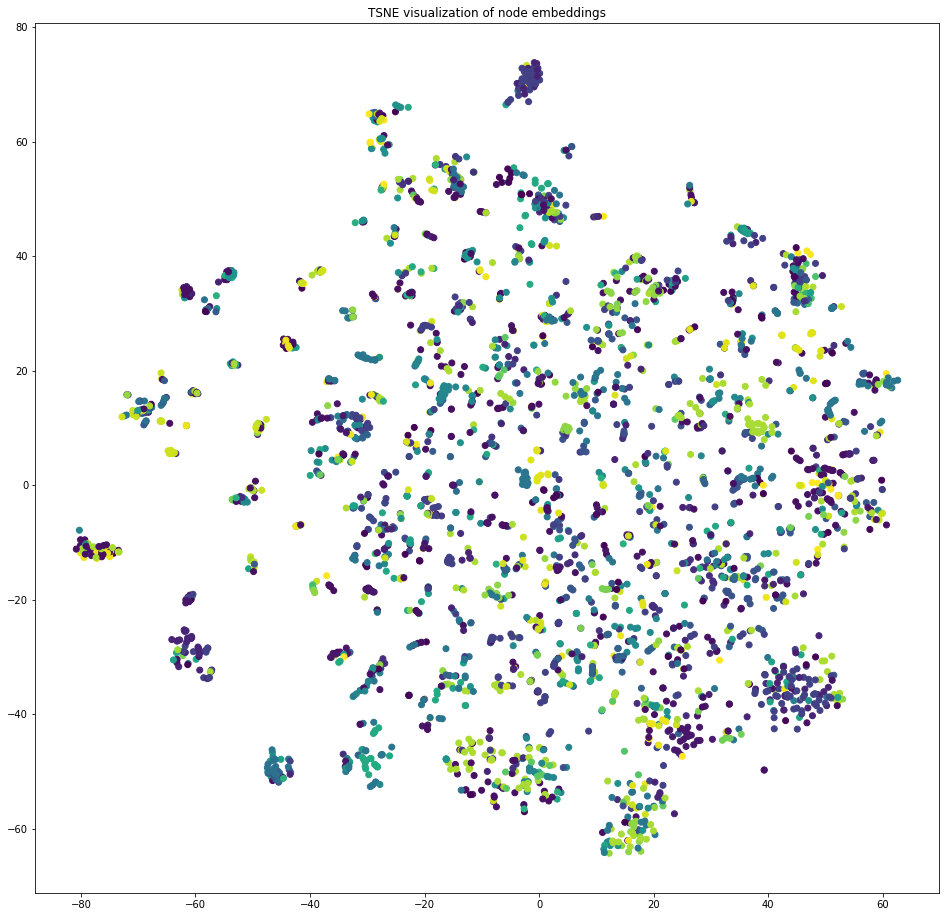

In [0]:
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=km.labels_.astype(float))
#plt.scatter(data[:,0], data[:,1], c=km.labels_.astype(float))
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

Movies only


In [0]:
import operator
def cosst1(number,km):
  cost1=0
  for i in range(number):
    EGO= nx.Graph()
    c=movies_vec[ClusterIndicesComp(i, km.labels_)]
    for j in range(len(c)):
      d=model.similar_by_vector(c[j])
      d=dict(d)
      
      f=max(d.items(), key=operator.itemgetter(1))[0]
      
      P=nx.ego_graph(A,str(f))
      EGO = nx.compose(P,EGO)
    nx.connected_components(EGO)
    Gc = max(nx.connected_component_subgraphs(EGO), key=len)
    number_of_nodes=Gc.number_of_nodes()
    cost_culus=number_of_nodes/len(c)
    cost1+=cost_culus
    
  costs1=cost1/number
  return costs1

  

    



In [0]:
def cosst2(number,km):
  cost2=0
  for i in range(number):
    EGO= nx.Graph()
    c=movies_vec[ClusterIndicesComp(i, km.labels_)]
    for j in range(len(c)):
      d=model.similar_by_vector(c[j])
      d=dict(d)
      
      f=max(d.items(), key=operator.itemgetter(1))[0]
      P=nx.ego_graph(A,str(f))
      EGO = nx.compose(P,EGO)
    deg=EGO.degree()
    deg=dict(deg)
    deg_sum=sum(deg.values())
    X = {n for n, d in EGO.nodes(data=True) if d['bipartite']==0}
    Y = set(EGO) - X
    cost2_culus= deg_sum/len(Y)
   
    cost2+=cost2_culus
    
  costs2=cost2/number
 
  return costs2

In [0]:
import operator
from sklearn.cluster import KMeans
dict_cost={}
for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
  km = KMeans(n_clusters=number_of_clusters, random_state=0).fit(movies_vec)
  cost1=cosst1(number_of_clusters,km)
  cost2=cosst2(number_of_clusters,km) 
  
  Cost = cost1*cost2
  
  dict_cost.update({number_of_clusters:Cost}) 
cluster_max_cost=max(dict_cost.items(), key=operator.itemgetter(1))[0]
print(dict_cost)
print("cluster with maximum cost",cluster_max_cost)

{3: 31.194424805574904, 5: 38.55011978191227, 10: 35.239512091097914, 30: 45.881356249492526, 50: 51.986000315695335, 100: 43.91903760475078, 200: 35.00090139924408, 500: 26.169493405002537}
cluster with maximum cost 50


In [0]:
km = KMeans(n_clusters=50, random_state=0).fit(movies_vec)
labels_node=km.labels_


In [0]:
# Retrieve node embeddings and corresponding subjects
node_ids=[]
node_embeddings=[]
for i in range(50):
  c=movies_vec[ClusterIndicesComp(i, labels_node)]
  
  for j in range(len(c)):
    node_embeddings.append(c[j])
    d=model.similar_by_vector(c[j])
    d=dict(d)
      
    f=max(d.items(), key=operator.itemgetter(1))[0]
    node_ids.append(f)
#node_ids = model.wv.index2word  # list of node IDs
node_embeddings=numpy.array(node_embeddings)

#  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [0]:
from sklearn.manifold import TSNE
transform = TSNE #PCA
#node_embeddings = model.wv.vectors
#print(type(node_embeddings))
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

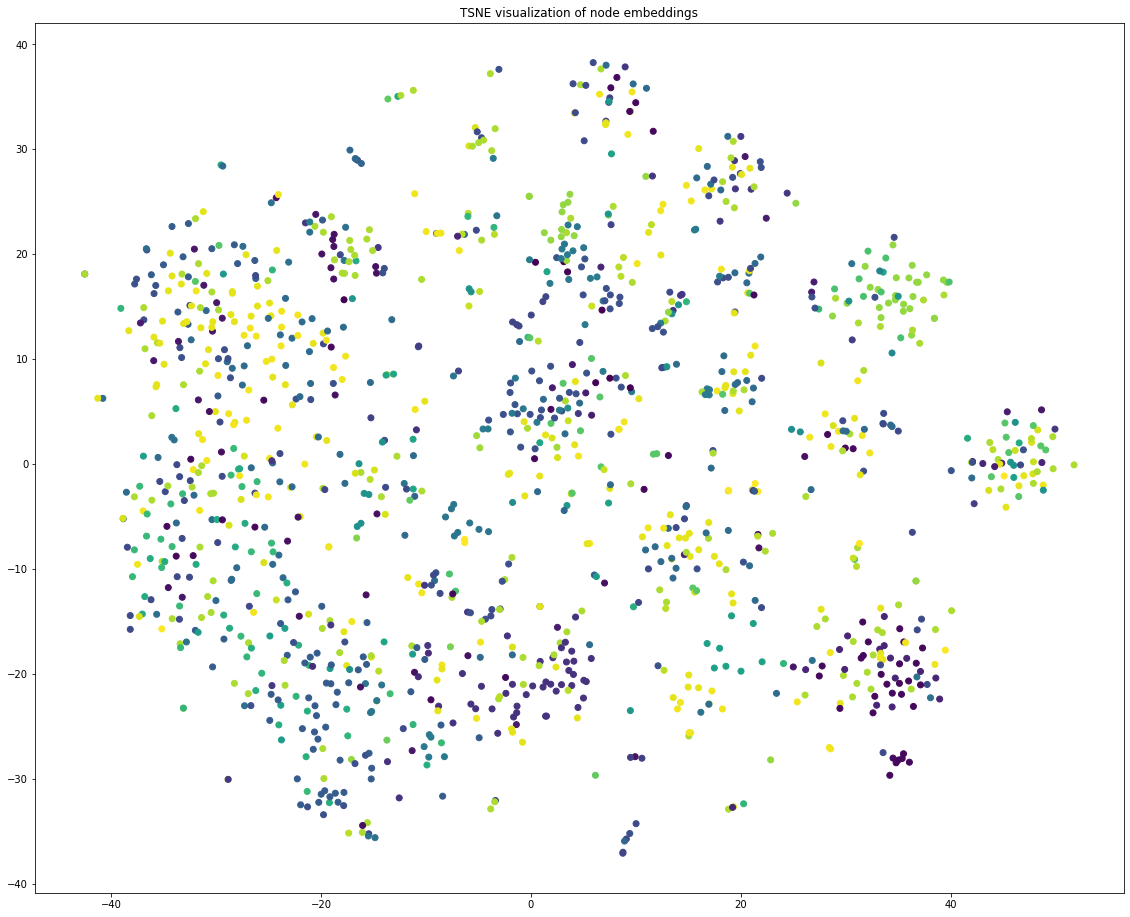

In [0]:
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=km.labels_.astype(float))
#plt.scatter(data[:,0], data[:,1], c=km.labels_.astype(float))
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()